# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [28]:
# TODO
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',index_col=0)
df.head()
#   df = pd.read_excel(...)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [29]:
# TODO
#  df1 = ...
df1=df.fillna(df.mean())
df1

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,1.057971,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,1.081150,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,0.884342,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s


## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [30]:
# TODO
yvalue = df1['Genotype'].values
valu,y = np.unique(yvalue, return_inverse=True)
y
#   y = ...

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

As predictors, get all but the last four columns of the dataframes.  Store the data matrix into `X` and the names of the columns in `xnames`.

In [31]:
# TODO


#   xnames = ...
xnames = df1.columns[:-4]
X = np.array(df1[xnames].values)

#   X = ...
Xs= preprocessing.scale(X)
Xs

array([[ 0.31271112,  0.5179336 ,  2.2536689 , ..., -1.41662394,
        -1.60789061,  1.06590091],
       [ 0.35679793,  0.28650133,  1.8802795 , ..., -1.32521803,
        -1.54684392,  1.28029118],
       [ 0.33496588,  0.45046461,  2.01292763, ..., -1.37325709,
        -1.62359464,  1.85703831],
       ...,
       [-0.79192771, -0.88354273, -1.72382963, ...,  1.27078193,
         3.11724261,  0.29352469],
       [-0.82188815, -0.8130138 , -1.52387571, ...,  1.88117889,
         3.32828966,  0.2089962 ],
       [-0.49491588, -0.62125474, -1.26845332, ...,  1.92748438,
         3.32672533,  0.10478825]])

Split the data into training and test with 30% allocated for test.  You can use the train

In [32]:
from sklearn.model_selection import train_test_split
Xtr,Xts,ytr,yts=train_test_split(Xs,y,test_size=0.3,random_state=1)

Xts

# TODO:
#   Xtr, Xts, ytr, yts = ...

array([[-1.06049490e-01, -4.80372847e-01,  1.01021150e+00, ...,
        -7.65791965e-16,  5.77678123e-16,  4.42088043e-01],
       [-6.20737026e-01, -6.96861509e-01,  1.54462372e-02, ...,
        -7.65791965e-16,  3.96240187e+00, -1.76162793e+00],
       [-4.22422563e-01, -4.46626235e-01, -4.23196734e-01, ...,
        -7.65791965e-16,  5.77678123e-16, -5.70440820e-01],
       ...,
       [-6.09992757e-01, -7.25427134e-01, -2.75922436e-02, ...,
        -7.65791965e-16,  5.77678123e-16, -8.72538043e-01],
       [-6.13555773e-01, -5.79019856e-01, -1.08458362e+00, ...,
         1.11767834e+00,  7.53623026e-01, -7.69839161e-01],
       [-2.44824718e-01, -5.37477834e-01, -1.32865138e-01, ...,
         1.48282487e+00,  1.80008372e-01,  2.81248435e-01]])

Scale the data with the `StandardScaler`.  Store the scaled values in `Xtr1` and `Xts1`. 

In [33]:
from sklearn.preprocessing import StandardScaler

# TODO
#  Xtr1 = ...
 #X_scaled.std
Xtr1=preprocessing.scale(Xtr) 
Xtr1.mean(axis=0)
Xtr1.std(axis=0)
Xtr1
#  Xts1 = ...
Xts1=preprocessing.scale(Xts)
Xts1.mean(axis=0)
Xts1.std(axis=0)
Xts1


array([[-0.08882245, -0.43259214,  1.07055475, ..., -0.04851572,
        -0.06118622,  0.41411079],
       [-0.55458685, -0.64739802,  0.06487286, ..., -0.04851572,
         3.71092846, -1.71585461],
       [-0.37512298, -0.39910784, -0.37858381, ..., -0.04851572,
        -0.06118622, -0.56453232],
       ...,
       [-0.54486386, -0.6757416 ,  0.02136207, ..., -0.04851572,
        -0.06118622, -0.85651941],
       [-0.5480882 , -0.53047236, -1.04722881, ...,  0.99503529,
         0.65624542, -0.7572575 ],
       [-0.21440653, -0.48925324, -0.08506609, ...,  1.33596436,
         0.11017758,  0.25865391]])

Create a `LogisticRegression` object `logreg` and `fit` on the scaled training data.  Set the regularization level to `C=1e5` and use the optimizer `solver=liblinear`. 

In [34]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5,solver='liblinear')
logreg.fit(Xtr1,ytr)
#   logreg = ...

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Measure the accuracy of the classifer on test data.  You should get around 94%.  

In [35]:
# TODO
#   yhat = ...
yhat = logreg.predict(Xts1)
acc = np.mean(yhat == yts)
print('Accuracy on the training data is {0:f}'.format(acc))


Accuracy on the training data is 0.944444


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  Jse the `plt.stem()` function with the `use_line_collection=True` option.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<StemContainer object of 3 artists>

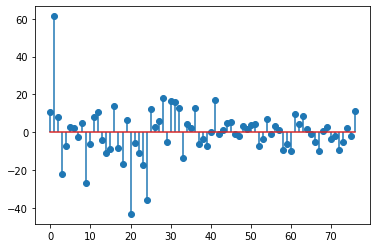

In [36]:
# TODO
#   W = ...
#   plt.stem(...)
W = logreg.coef_
W = W.ravel()
plt.stem(W,use_line_collection=True)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.   Below we will use L1 regression to enforce sparsity.  Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [37]:
# TODO
ind=np.argsort(np.abs(W))
i1=ind[-1]#first largest element
i2=ind[-2] #second largest element
nam1=xnames[i1]
nam2=xnames[i2]
print('The two most significant genes are {0:s} and {1:s}'.format(nam1, nam2))

The two most significant genes are ITSN1_N and BRAF_N


## Cross Validation

To obtain a slightly more accurate result, now perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

# TODO
precision=[]
f1_score =[]
error_rate=[]
recall=[]
acc = []
x=np.array(X)

for tr,ts in kf.split(X):
    Xtr=x[tr,:]
    ytr=y[tr]
    Xts=x[ts,:]
    yts=y[ts]
    
    
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts) 
    logreg.fit(Xtr,ytr)
    
    
    
    yhat=logreg.predict(Xts)
    p,r,f,s=precision_recall_fscore_support(yts,yhat,average='binary')
    
    precision.append( p)
    recall.append(r)
    f1_score.append(f)
    
    error_rate.append(np.mean(yts != yhat))
    acc.append(np.mean(yhat == yts))
    
mean_precision=np.mean(precision)
mean_f1_score=np.mean(f1_score)
mean_error_rate=np.mean(error_rate)
mean_recall=np.mean(recall)
mean_acc = np.mean(acc)

print('The mean precision =',mean_precision)
print('The mean f1 score =',mean_f1_score) 
print('The mean error rate =',mean_error_rate)
print('The mean recall =',mean_recall)
print('The mean accuracy =',mean_acc )
#compare between the accuracy after using cross validation
if mean_acc> score:
    print("10-fold cross validation gives more accurate result ")




# TODO

The mean precision = 0.9534864560037952
The mean f1 score = 0.9533460704876922
The mean error rate = 0.04351851851851852
The mean recall = 0.9545682096898178
The mean accuracy = 0.9564814814814815


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [39]:
# TODO
#   y = ...
y=df1['class'].values
u,ymulti=np.unique(y,return_inverse=True)
ymulti

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

In [42]:
Xtr, Xts, ytr, yts =  train_test_split(X, ymulti, test_size=0.3, random_state=1,shuffle=True)
from sklearn.preprocessing import StandardScaler


#  Xtr1 = ...
Xtr1=preprocessing.scale(Xtr)
Xtr1.mean(axis=0)
Xtr1.std(axis=0)
Xtr1
#  Xts1 = ...
Xts1=preprocessing.scale(Xts)
Xts1.mean(axis=0)
Xts1.std(axis=0)
Xts1
logreg = linear_model.LogisticRegression(C=1,solver='liblinear',multi_class='auto')
logreg.fit(Xtr1,ytr)
yhat = logreg.predict(Xts1)
acc = np.mean(yhat == yts) 
W = logreg.coef_
print('The multiclass accuracy is: ',acc)


The multiclass accuracy is:  0.9753086419753086


In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TOD
acc = []
precd = []
rec = [] 
f1 = [] 
kf = KFold(n_splits=10,shuffle=True)
Cf = np.zeros((8,8))
x=np.array(X)

for tr,ts in kf.split(X):
    Xtr = x[tr,:]
    ytr = y[tr]
    Xts = x[ts,:]
    yts = y[ts]
    
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts) 
   
    logreg.fit(Xtr1,ytr)
    yhat = logreg.predict(Xts1)
    
    acc.append(np.mean(yhat == yts))
    
    p, r, f, s = precision_recall_fscore_support(yts,yhat)
    
    f1.append(f)
    precd.append(p)
    rec.append(r)
    Cf = Cf + confusion_matrix(yts,yhat)
    
mean_f1 = np.mean(f1)
mean_acc = np.mean(acc)   
mean_prec = np.mean(precd)
mean_rec = np.mean(rec)
sd_acc = np.std(acc)
Cf = Cf/Cf.sum(axis=1)

print(np.array_str(Cf, precision=4, suppress_small=True))
print('The mean and std error of the test accuracy =',mean_acc ,"and" ,sd_acc)


[[0.96   0.0148 0.0067 0.     0.0222 0.     0.     0.    ]
 [0.0067 0.9778 0.     0.     0.0074 0.0095 0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.0133 0.     0.     0.9852 0.     0.     0.     0.    ]
 [0.0067 0.0148 0.     0.     0.9778 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.0067 0.0074 0.     0.     0.9852 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
The mean and std error of the test accuracy = 0.9851851851851852 and 0.013857990321384961


Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

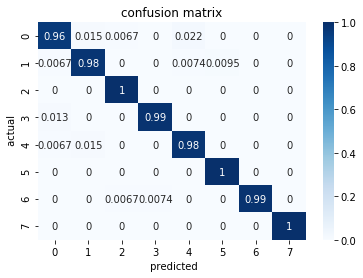

In [44]:
import seaborn as sn
fig= sn.heatmap(Cf,annot=True,cmap="Blues")
fig.set_xlabel(" predicted")
fig.set_ylabel(" actual")
fig.set_title("confusion matrix")
plt.show()
# TODO

Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Text(0, 0.5, 'weight coefficients')

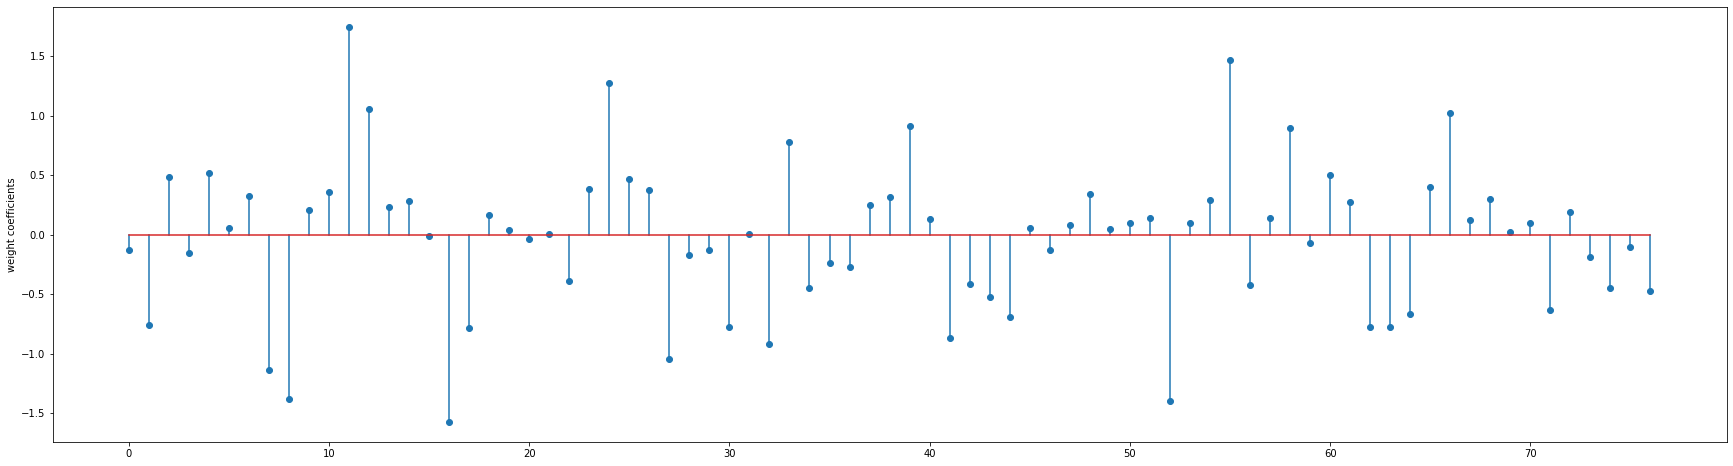

In [45]:
logreg = linear_model.LogisticRegression()
logreg.fit(X,y)

plt.figure(figsize=(30,8))
plt.stem(W[0,:])
plt.ylabel('weight coefficients')

## L1-Regularization

This section is bonus.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [housing demo](../unit05_lasso/demo2_housing.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

In [20]:
# TODO

In [47]:
kf = KFold(n_splits=10,shuffle=True)
nf=10
C = np.logspace(-1,2,20)
nz = np.zeros((20,nf))
er = np.zeros((20,nf))

x=np.array(X)

for i,k in enumerate(C): 
    j=0
    for tr,ts in kf.split(X):
        Xtr = x[tr,:] 
        ytr = y[tr]
        Xts = x[ts,:]
        yts = y[ts] 

        logreg = linear_model.LogisticRegression(penalty='l1',C=k,solver='liblinear',multi_class='auto')
        scal = StandardScaler()
        Xtr1 = scal.fit_transform(Xtr)
        Xts1 = scal.transform(Xts) 
   
        logreg.fit(Xtr1,ytr)
        yhat = logreg.predict(Xts1)

        er[i,j] = np.mean(yhat != yts)
        nz[i,j] = np.sum(logreg.coef_[0,:] > 0.01)
        j=j+1
mean_error = np.mean(er,axis=1)
std_error = np.std(er,axis=1)
print("std_error",std_error)


std_error [0.01645962 0.01861088 0.00769132 0.00873517 0.01296296 0.00833333
 0.01031067 0.00648148 0.00807204 0.00648148 0.006929   0.00925926
 0.00498626 0.00717219 0.00807204 0.0105165  0.00997253 0.00769132
 0.00925926 0.00997253]


<function matplotlib.pyplot.show(*args, **kw)>

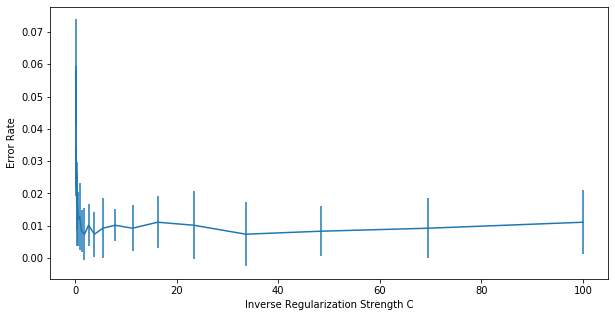

In [48]:
plt.figure(figsize=(10,5))
plt.errorbar(C,mean_error,std_error)
plt.xlabel('Inverse Regularization Strength C')
plt.ylabel('Error Rate')
plt.show


In [49]:
C_min = C[np.argmin(mean_error)]
min_error = np.min(mean_error)
print('The min error =',min_error, "and C=",C_min)

The min error = 0.007407407407407407 and C= 1.8329807108324356


In [50]:
min = np.argmin(mean_error) 
for i in range(min):
    if mean_error[i]<=mean_error[min]+std_error[min]: 
        C_optimal = C[i]
        break
print(' optimal C =',C_optimal)

 optimal C = 0.6158482110660264


 number of Non Zero Coefficients for optimal C = 20.5


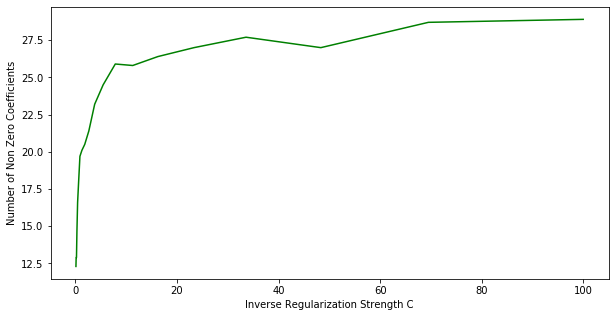

In [51]:
mean_nz= np.mean(nz,axis = 1) 
plt.figure(figsize=(10,5)) 
plt.plot(C,mean_nz, 'g-') 
plt.xlabel('Inverse Regularization Strength C')
plt.ylabel('Number of Non Zero Coefficients')
print(' number of Non Zero Coefficients for optimal C =',mean_nz[min])

(8, 77)
Accuracy of training data(for Optimal C)=  0.9166666666666666
 The accuracy is improved using l1.


C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


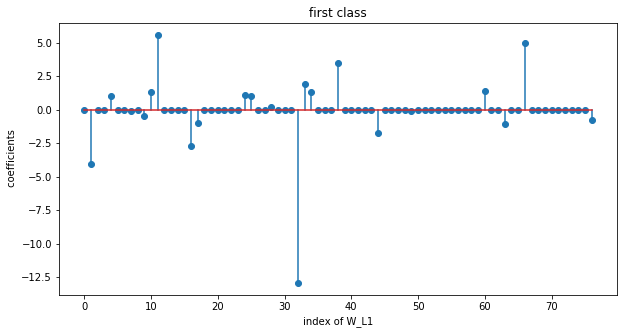

In [54]:
logreg = linear_model.LogisticRegression(C = C_optimal,solver= 'liblinear',penalty='l1',warm_start=True) 
logreg.fit(X,y)
yhat= logreg.predict(X)
W_l1 = logreg.coef_
print(W_l1.shape)
plt.figure(figsize=(10,5))
plt.stem(W_l1[0])
plt.xlabel("index of W_L1")
plt.ylabel(' coefficients')
plt.title("first class")

Accuracy= np.mean(y==yhat)
print("Accuracy of training data(for Optimal C)= ",Accuracy)
print(' The accuracy is improved using l1.')

(8, 77)


C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Accuracy of training data at Optimal C  0.9157407407407407


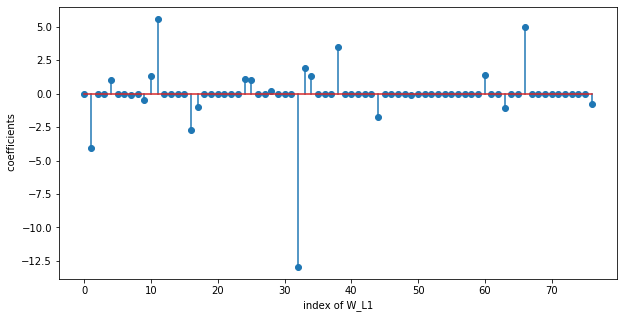

In [56]:
logreg = linear_model.LogisticRegression(C = C_optimal,solver= 'liblinear',penalty='l1',warm_start=True) 

logreg.fit(X,y)
yhat= logreg.predict(X)
W_l1 = logreg.coef_
print(W_l1.shape)
plt.figure(figsize=(10,5))
plt.stem(W_l1[0])
plt.xlabel("index of W_L1")
plt.ylabel(' coefficients')


Accuracy= np.mean(y==yhat)
print("Accuracy of training data at Optimal C ",Accuracy)
if Accuracy> score:
    print(' The accuracy is improved using l1.')